# MCT4001 Scientific Computing in Python Session 9
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy (if not we have to specify scipy.signal)
from scipy import signal


# defining funtions that will be used in this notebook

def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    #plt.ylim([-1,1])
    plt.title(title)
    plt.show()

def myPlotLine(signal,title):
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.grid(True)
    #plt.ylim([-1,1])
    plt.title(title)
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 3))
    librosa.display.waveplot(s, sr=sr)
    plt.title(title)
    plt.show()

def myFiltResponse(b,a,sr,title):
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

def myFiltGroupDelay(b,a,sr,title):
    w, gd = scipy.signal.group_delay((b, a))
    plt.title(title)
    plt.plot(w/math.pi, gd)
    plt.ylabel('Group delay [samples]')
    plt.xlabel('Normalized Frequency')
    plt.show()


In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

## 1. Matched Filter

A matched filter (FIR type) can identify a signal/pattern in an incoming stream of data (even if buried in some noise/interference). The coefficients of the filter are the same samples of the signal/pattern to detect but in reversed (flipped) order.

When the output of the filter is above a manually determined threshold, the signal has been detected (i.e. the last sample of the signal/patter has just entered the filter).


[ 0.45  0.4  -0.35 -0.3   0.25  0.2  -0.15 -0.1 ]
[-0.1  -0.15  0.2   0.25 -0.3  -0.35  0.4   0.45]


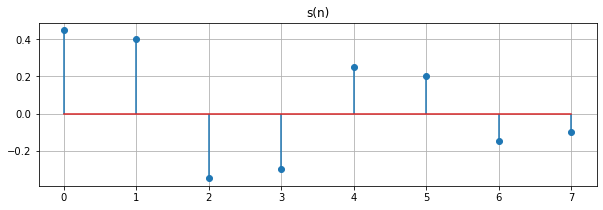

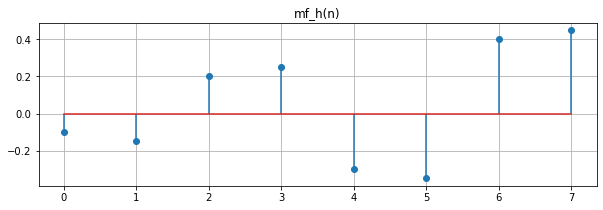

In [3]:
# signal/pattern to be detected by the matched filter
s = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])

# desgning matched filter impulse response (i.e. reversing the signal)
mf_h = s[::-1]

#alternative is np.fliplr(sig) or flip(sig, 1) but require 2D array
#s = np.reshape(s,[1,s.size])
#mf_h = np.fliplr(s)

print(s)
print(mf_h)

myPlotStem(s, 's(n)')
myPlotStem(mf_h, 'mf_h(n)')


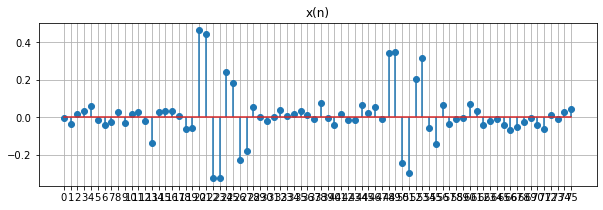

In [4]:
# creating a long signal which embeds multiple noisy copies of the signal to find

x = np.zeros([1,20])
x = np.append(x,s)
x = np.append(x,np.zeros([1,20]))
x = np.append(x,s)
x = np.append(x,np.zeros([1,20]))

# adding noise
x = x + 0.05*np.random.randn(x.size)

myPlotStem(x, 'x(n)')


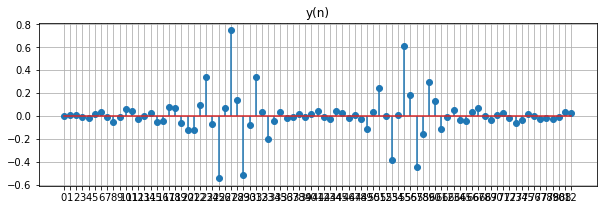

In [5]:
# computing matched filter output

y = np.convolve(x,mf_h)

#alternative
#y = signal.lfilter(mf_h, 1, x)

myPlotStem(y, 'y(n)')

In [6]:
# manually setting a threshold
# and using it to find prersence of s at the output of the matched filter

threshold = 0.6

s_detect = np.argwhere(y > threshold)

print('s detected at')
print(s_detect)

# note that in x (refer to the plot or to its construction)
# the two copies of s terminates exactly at index 27 and 55
# i.e. the matched filter output is "very positive" when the
# last sample of s enters the filter

s detected at
[[27]
 [55]]


#### Task 1

Experiment with the matched filter changing *s* (the signal/pattern to be detected) and/or how *x* is constructed from *s* (position, amount of noise etc). Depending on the amount of noise, you may have to adjust the threshold.

If you wish to experiment with audio as *s* to be detected, use a very short sample (less than a second) and use a very low sampling rate (e.g. 8000 or less).

## 2. Cascade and Parallel of Filters

Computing output and overall response of cascade (a) or parallel (b) of filters. This is useful to achieve "composite" filters with a more complex response starting from simple one. This is quite common with IIR (used in the following examples), but the same method applies for FIR.

![Parallel vs Cascade](https://flylib.com/books/2/729/1/html/2/images/0131089897/graphics/06fig37.gif "Parallel vs Cascade")

### 2.1 Cascade

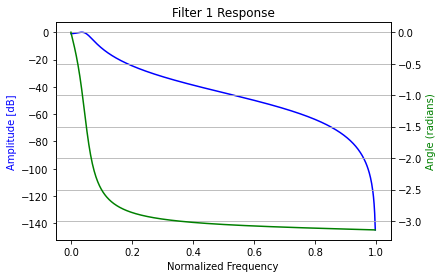

In [7]:
#second filter second order low pass
sr = 48000
order = 2
fc = 0.05
b1, a1 = signal.cheby1(2, 1, fc, 'low', analog=False)

# displaying response
myFiltResponse(b1,a1,sr,'Filter 1 Response')

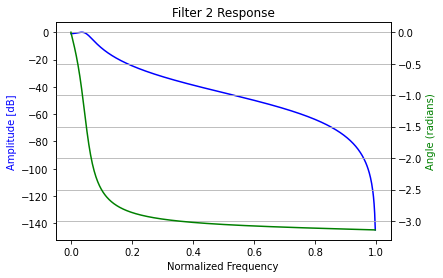

In [8]:
#second filter second order low pass
sr = 48000
order = 2
fc = 0.05
b2, a2 = signal.cheby1(2, 1, fc, 'low', analog=False)

# displaying response
myFiltResponse(b2,a2,sr,'Filter 2 Response')

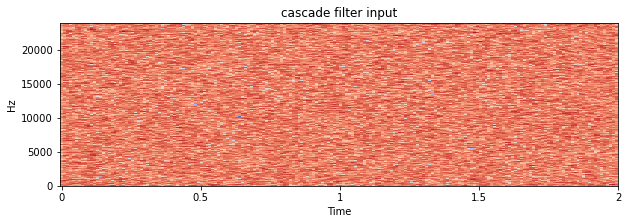

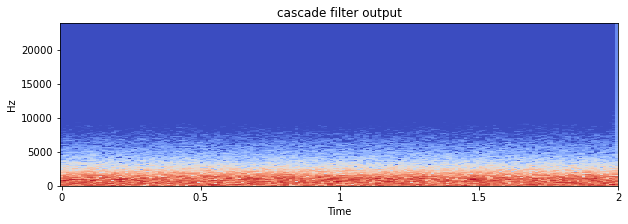

In [9]:
#applying the cascade
x = np.random.normal(0, 0.1, 2*sr)

# computing the output (filtering the signal twice)
y = signal.lfilter(b1, a1, x)
y = signal.lfilter(b2, a2, y) # note that here the input is the output of the previous filter

#displaying results
mySpectrogram(x, sr, 'cascade filter input')
mySpectrogram(y, sr, 'cascade filter output')

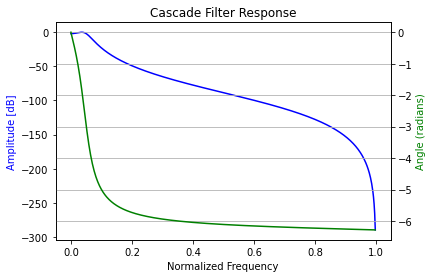

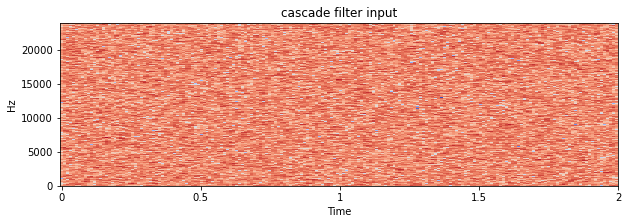

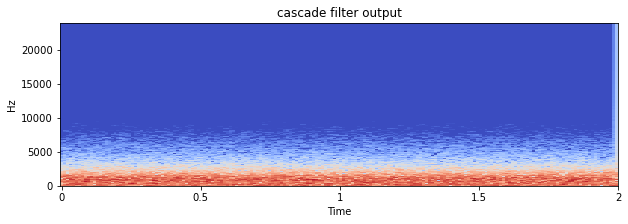

In [10]:
# to compute the cascade it is sufficnent
# to perform the convolution between
# the two numerators (a) and denominators (b) coefficients

cascade_a = np.convolve(a1,a2)
cascade_b = np.convolve(b1,b2)

myFiltResponse(cascade_b,cascade_a,sr,'Cascade Filter Response')

#applying the cascade
x = np.random.normal(0, 0.1, 2*sr)

# computing the output
y = signal.lfilter(cascade_b, cascade_a, x)

#displaying results
mySpectrogram(x, sr, 'cascade filter input')
mySpectrogram(y, sr, 'cascade filter output')

# compare the frequency response of the cascade with the frequency responses
# of the individual filter composing the cascade, in particular, note the difference
# in the stop-band and around the cutoff frequency by looking at the left vertical axis (amplitude)

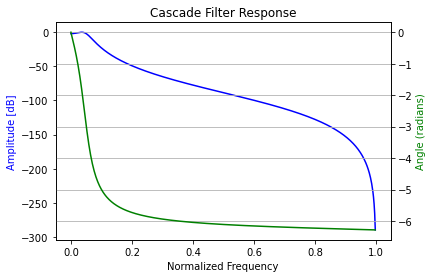

In [11]:
# to compute only  the response of the cascade
# we multiply the responses of the two filters (sum result of freqz)

w, h1 = signal.freqz(b1,a1)
w, h2 = signal.freqz(b2,a2)

h = h1 * h2

# the remaining is the code from myFiltResponse()
fig, ax1 = plt.subplots()
ax1.set_title('Cascade Filter Response')
ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Normalized Frequency')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/math.pi, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

original filter of order =  3
[0.02347075 0.01265091 0.01265091 0.02347075]
[ 1.         -2.27428592  1.97927811 -0.63274888]


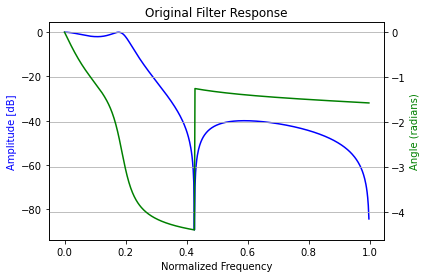

second order sections
[[ 0.02347075  0.02347075  0.          1.         -0.77233058  0.        ]
 [ 1.         -0.46099232  1.          1.         -1.50195534  0.81927207]]



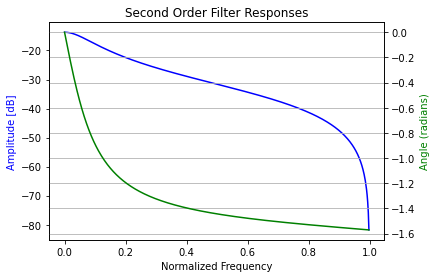

[0.02347075 0.02347075 0.        ]
[ 1.         -0.77233058  0.        ]


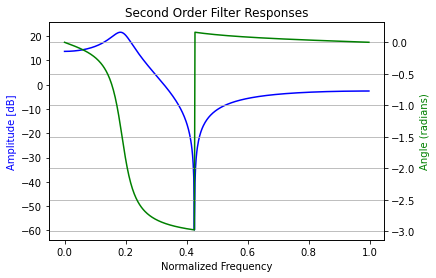

[ 1.         -0.46099232  1.        ]
[ 1.         -1.50195534  0.81927207]


In [12]:
# at times it may be convenient to convert
# a long filter (either FIR or IIR) into a cascade of second order IIRs
# (this is recommended only if necessary, eg in PD we have only biquad)
# the drawback is a drop in numerical precision (often negligible)

# designing low pass IIR filter with iirdesign (we cannot specify the order)

sr = 48000
wp = 0.2 # passband edge frequency
ws = 0.4 # stopband edge frewuency
gpass = 2 # maximum loss in the passband (dB).
gstop = 40 # minimum attenuation in the stopband (dB).

[b,a] = signal.iirdesign(wp, ws, gpass, gstop)

sos = signal.tf2sos(b,a)

print('original filter of order = ',b.size-1)
print(b)
print(a)
myFiltResponse(b,a,sr,'Original Filter Response')

signal.sos2tf(sos)
print('second order sections')
print(sos)
print('')

# in second order representation a and b are arranged  as follow in a single array 
# [b0,b1,b2,a0,a1,a2]
for section in sos:
    b = section[0:3]
    a = section[3:6]
    myFiltResponse(b,a,sr,'Second Order Filter Responses')
    print(b)
    print(a)
    
# generally in scipy we can work with sos representation
# we can apply  a filter in sos form using sosfilt()


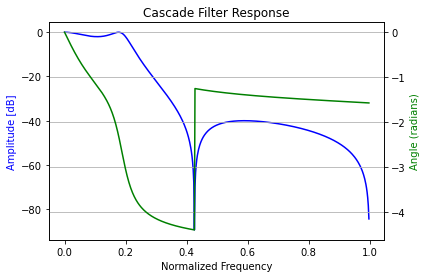

In [13]:
# further checking that the cascade of the two biquad
# matches the response of the original filter

# the code below works only if starting from a 4th order filter
b1 = sos[0,0:3]
a1 = sos[0,3:6]
b2 = sos[1,0:3]
a2 = sos[1,3:6]

cascade_a = np.convolve(a1,a2)
cascade_b = np.convolve(b1,b2)

myFiltResponse(cascade_b,cascade_a,sr,'Cascade Filter Response')


### 2.1 Parallel

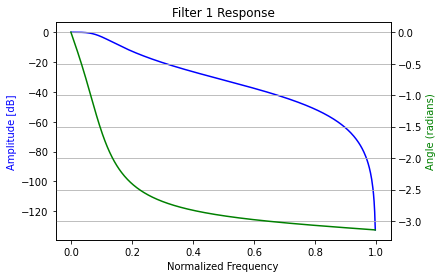

In [14]:
#first filter second order low pass
sr = 48000
order = 2
fc = 0.1
b1,a1 = signal.butter(order, fc, 'low', analog=False)

# displaying response
myFiltResponse(b1,a1,sr,'Filter 1 Response')


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_8044/3320305499.py:61: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')


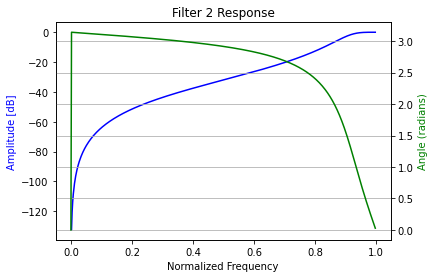

In [15]:
#second filter second order high pass
sr = 48000
order = 2
fc = 0.9
b2,a2 = signal.butter(order, fc, 'high', analog=False)

# displaying response
myFiltResponse(b2,a2,sr,'Filter 2 Response')


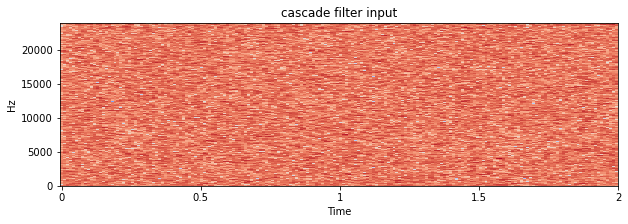

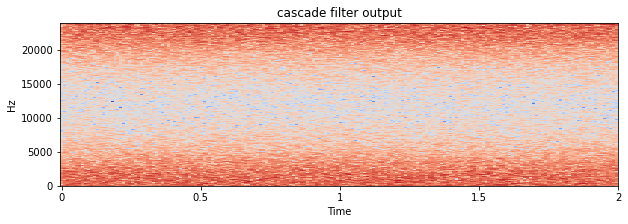

In [16]:
#applying the cascade
x = np.random.normal(0, 0.1, 2*sr)


y = signal.lfilter(b1, a1, x)
y = signal.lfilter(b2, a2, y) 

# computing the output (filtering the signal twice)
y1 = signal.lfilter(b1, a1, x) # the input is still the overall parallel filter input
y2 = signal.lfilter(b2, a2, x) # the input is still the overall parallel filter input

# to compute the overall parallel filter output we sum the two individual outputs
y = y1 + y2

#displaying results
mySpectrogram(x, sr, 'cascade filter input')
mySpectrogram(y, sr, 'cascade filter output')

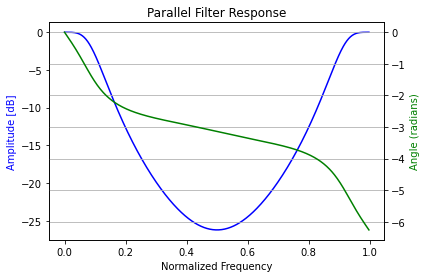

In [17]:
# to compute the response of the parallel
# we sum the responses of the two filters (sum result os freqz)

w, h1 = signal.freqz(b1,a1)
w, h2 = signal.freqz(b2,a2)

h = h1 + h2

# the remaining is the code from myFiltResponse()
fig, ax1 = plt.subplots()
ax1.set_title('Parallel Filter Response')
ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Normalized Frequency')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/math.pi, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

# compare the frequency response of the parallel with the frequency responses
# of the individual filter composing the parallel

#### Task 2

Design and verify (by plotting the frequency response and by filtering an arbitrary signal) a pass-band filter using the cascade of two IIR.

## 3. Filtering noisy signals & DC removal

Besides EQ-like applications, filters are also commonly used to remove noise from signals (typically a low-pass removing undesired high-frequency components) and to remove DC bias/offset from signals (typically a high-pass with a quite low cutoff frequency). In both cases, the specific cutoff frequency and stop-band attenuation is application-specific (i.e. you have to consider frequency and amplitude of the "useful" signals you do not wish to filter out).

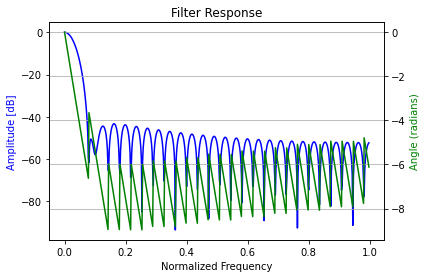

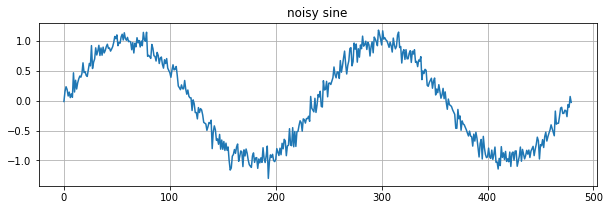

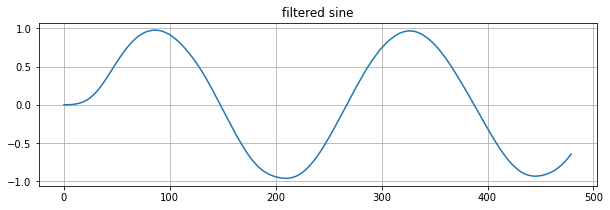

In [18]:
# designing low pass FIR filter with firwin

sr = 48000
numtaps = 55
fc = 0.01 
b = signal.firwin(numtaps, fc, pass_zero=True)

# displaying response
myFiltResponse(b,1,sr,'Filter Response')

# noise sine signal
x = mySineSynth(freq=200, dur_ms=10, sr=sr) + np.random.normal(0, 0.1, int(0.01*sr))

myPlotLine(x,'noisy sine')

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)

myPlotLine(y,'filtered sine')


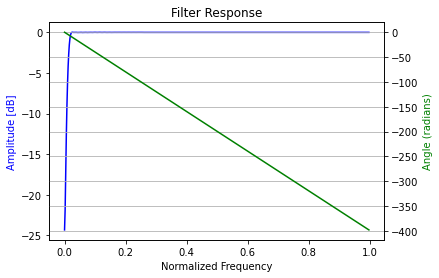

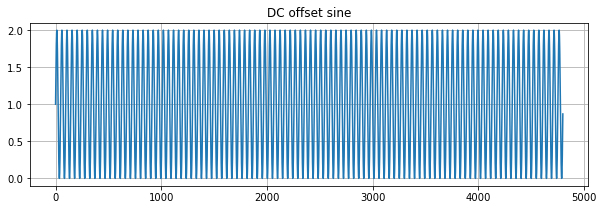

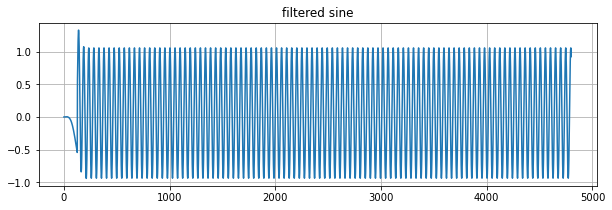

In [19]:
# designing high pass FIR filter with firwin

sr = 48000
numtaps = 255
fc = 0.01
b = signal.firwin(numtaps, fc, pass_zero=False)

# displaying response
myFiltResponse(b,1,sr,'Filter Response')

# sine signal with DC offset
x = mySineSynth(freq=1000, dur_ms=100, sr=sr) + 1

myPlotLine(x,'DC offset sine')

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)

# note the difference on the "center" of the sine on the vertical axis
myPlotLine(y,'filtered sine')


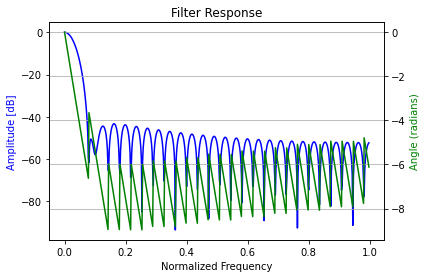

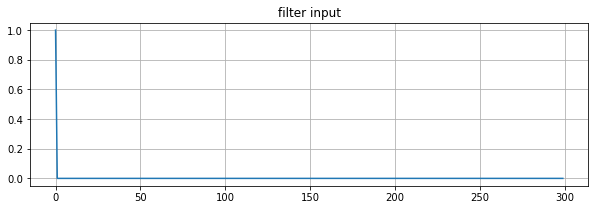

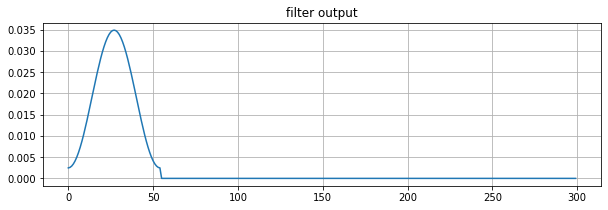

In [20]:
# designing low pass FIR filter with firwin and displaying impulse response

sr = 48000
numtaps = 55
fc = 0.01 
b = signal.firwin(numtaps, fc, pass_zero=True)

# displaying response
myFiltResponse(b,1,sr,'Filter Response')

# impulse
x = signal.unit_impulse(300)

myPlotLine(x,'filter input')

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)

myPlotLine(y,'filter output')


## 3. Comb  Filters 

A [comb filter](https://en.wikipedia.org/wiki/Comb_filter) is a filter implemented by adding a delayed version of a signal to itself, causing constructive and destructive interference. The frequency response of a comb filter consists of a series of regularly spaced notches, giving the appearance of a comb.

In [21]:
# load filter input
sr = 48000
x, sr = librosa.load('./files/Loop.wav', sr=sr) 

241
241


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_8044/3320305499.py:61: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')


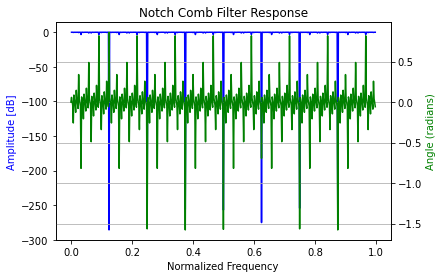

In [22]:
# notch comb

f0 = 200.0  # frequency to be removed from signal (Hz)
Q = 30.0  # quality factor

# design notching filter
b,a = signal.iircomb(f0, Q, ftype='notch', fs=sr)

print(a.size)
print(b.size)

myFiltResponse(b,a,sr,'Notch Comb Filter Response')

y = signal.lfilter(b,a,x)

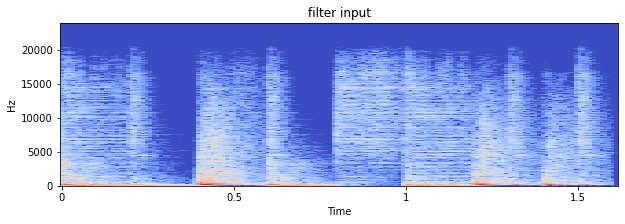

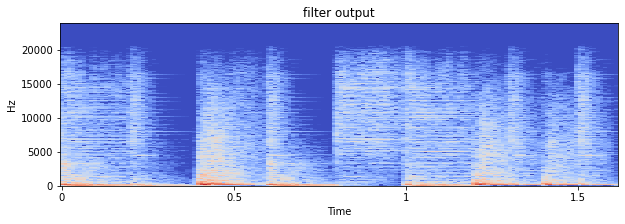

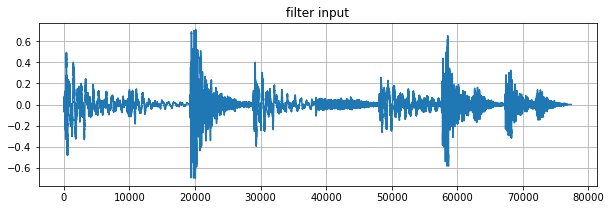

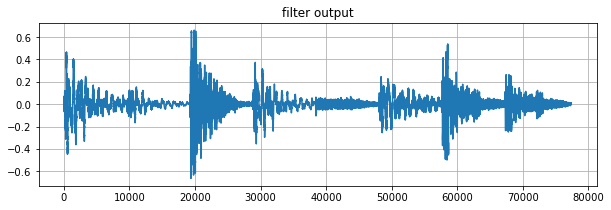

In [23]:
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')
myPlotLine(x,'filter input')
myPlotLine(y,'filter output')
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()


comb filter order =  24
25
25


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_8044/3320305499.py:61: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')


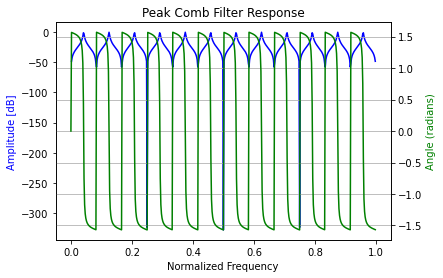

In [24]:
# peak comb

f0 = 2000.0  # frequency to be retained (Hz)
Q = 30.0  # quality factor

# design peaking filter
b,a = signal.iircomb(f0, Q, ftype='peak', fs=sr)

print('comb filter order = ',b.size-1)
print(a.size)
print(b.size)

myFiltResponse(b,a,sr,'Peak Comb Filter Response')

y = signal.lfilter(b,a,x)

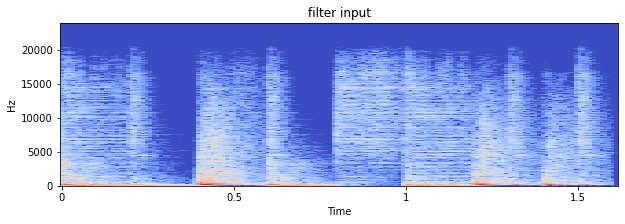

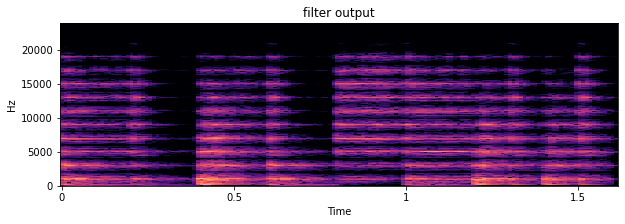

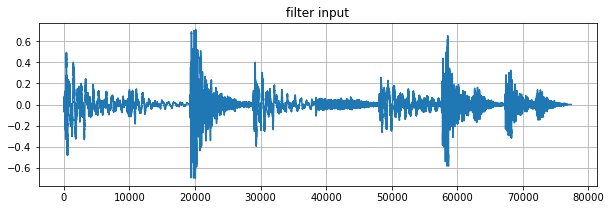

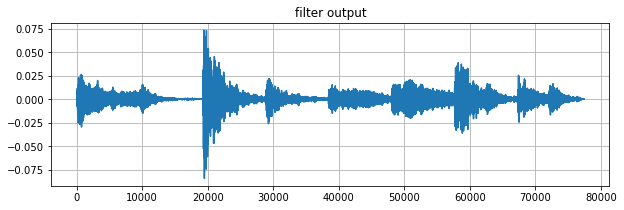

In [25]:
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')
myPlotLine(x,'filter input')
myPlotLine(y,'filter output')
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

## 4. All-pass Filters

An [all-pass filter](https://en.wikipedia.org/wiki/All-pass_filter) is a signal processing filter that passes all frequencies equally in gain, but changes the phase relationship among various frequencies. Most types of filter reduce the amplitude (i.e. the magnitude) of the signal applied to it for some values of frequency, whereas the all-pass filter allows all frequencies through without changes in level. There is no all-pass filter in scipy.signal, but a function to design it can be easily defined as it follows.

In [26]:
# function to design all pass
def allpass(delay, gain):
    b = np.zeros(delay)
    b[0] = gain
    b[delay-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[delay-1] = gain
    return b,a


[0.2 0.  0.  0.  0.  0.  0.  0.  0.  1. ]
[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.2]


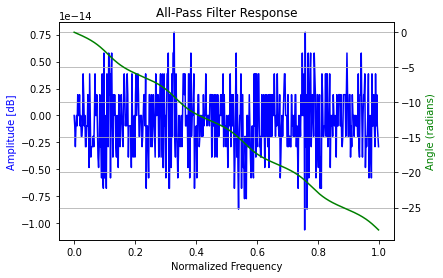

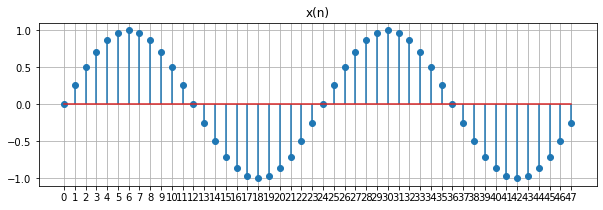

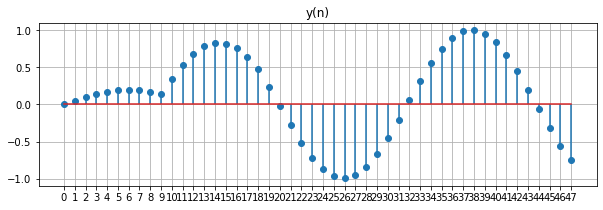

In [27]:
delay = 10  # delay in samples
gain = 0.2  # linear gain

x = mySineSynth(freq=2000, dur_ms=1, sr=sr)

# design all pass
b,a = allpass(delay, gain)

print(b)
print(a)

myFiltResponse(b,a,sr,'All-Pass Filter Response')

y = signal.lfilter(b,a,x)

myPlotStem(x, 'x(n)')
myPlotStem(y, 'y(n)')

# mind that at a first look the magnitude frequency response
# does not appear to be "flat", but pay a greater attention
# to the values (and the top exponent) on the vertical axis

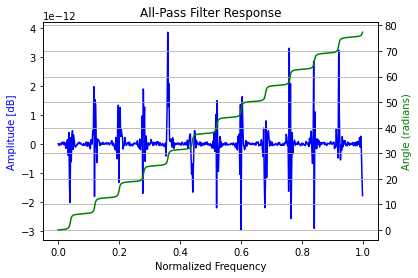

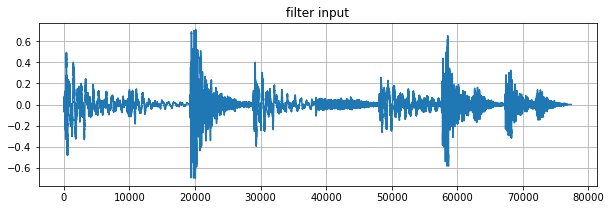

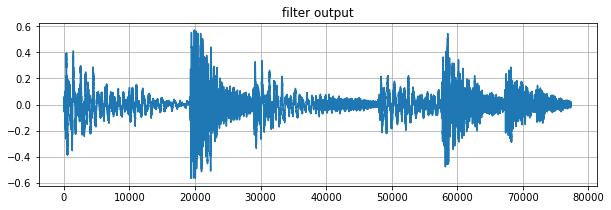

In [28]:
# load filter input
sr = 48000
x, sr = librosa.load('./files/Loop.wav', sr=sr) 

delay = 1000  # delay in samples
gain = 0.8  # linear gain

# design all pass
b,a = allpass(delay, gain)

myFiltResponse(b,a,sr,'All-Pass Filter Response')

y = signal.lfilter(b,a,x)

myPlotLine(x,'filter input')
myPlotLine(y,'filter output')
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

#### Task 3

Experiment with comb-filter (both peak and notch) and all-pass filters when the input is an audio file (the one included in this notebook or an arbitrary one). Simply listen to the output when changing filter parameters.

If you have time, experiment to put in cascade/parallel a few all-pass and comb-filters, perhaps obtaining a [Schroeder reverberator](https://ccrma.stanford.edu/~jos/pasp/Schroeder_Reverberators.html).